# Messages 
Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

here is the conversation regarding space between human and ai 

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Hey! You mentioned you’ve been following recent space missions?", name="Model")]
messages.append(HumanMessage(content="Yeah, I’ve been really fascinated by what NASA and SpaceX are doing.", name="Lance"))
messages.append(AIMessage(content="That’s exciting! Do you follow more of the moon missions or the Mars exploration projects?", name="Model"))
messages.append(HumanMessage(content="Mostly Mars missions — I want to know when humans might actually set foot there.", name="Lance"))

for m in messages:
    m.pretty_print()


================================== Ai Message ==================================
Name: Model

Hey! You mentioned you’ve been following recent space missions?
================================ Human Message =================================
Name: Lance

Yeah, I’ve been really fascinated by what NASA and SpaceX are doing.
================================== Ai Message ==================================
Name: Model

That’s exciting! Do you follow more of the moon missions or the Mars exploration projects?
================================ Human Message =================================
Name: Lance

Mostly Mars missions — I want to know when humans might actually set foot there.


# Chatmodel

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [3]:
result

AIMessage(content="The prospect of humans landing on Mars is really captivating! NASA’s Artemis program, though primarily focused on the Moon, is a critical step towards Mars, as it plans to use the Moon as a proving ground for technologies and logistics. Meanwhile, NASA's Mars 2020 mission with the Perseverance rover is actively exploring Mars and prepping for future crewed missions, focusing on collecting samples and studying the planet's habitability.\n\nSpaceX is pushing hard with its Starship project, intending to revolutionize space travel and make a Mars settlement possible. Elon Musk has talked about launching crewed missions to Mars as early as the 2030s, depending greatly on technology development and successful test flights.\n\nThere are still numerous challenges to overcome, like life-support systems, radiation protection, and sustainable living conditions, but the progress being made is truly promising. Would you be interested in traveling to Mars if the opportunity arose?

In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 182,
  'prompt_tokens': 89,
  'total_tokens': 271,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_cbf1785567',
 'id': 'chatcmpl-CRGeQtdUSndAXrIjuEzNP1Zo4a3QH',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

# Using Tools 
Let's showcase a simple example of tool calling!
here im building a simple calculator function which can sum , divide, add and multiply 

In [5]:


def add(a: int, b: int) -> int:
    """A function that adds two numbers"""
    return a + b;

def divide(a: int, b: int) -> int:
    """A function that divides two numbers"""
    return a / b;

def multiply(a: int, b: int) -> int:
    """A function that multiplies two numbers"""
    return a * b;

def subtract(a: int, b: int) -> int:
    """A function that subtracts two numbers"""
    return a - b;

tools=[add,divide,multiply,subtract]
llm_with_tools = llm.bind_tools(tools)

In [6]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 8 multiplied by 4", name="Lance")])
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_C3lY7nL6YZtGSqVdtJhiWPpb)
 Call ID: call_C3lY7nL6YZtGSqVdtJhiWPpb
  Args:
    a: 8
    b: 4


In [8]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 added with 4", name="Lance")])
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (call_xQ7JgPNxoDLmr82jpK79OWEB)
 Call ID: call_xQ7JgPNxoDLmr82jpK79OWEB
  Args:
    a: 2
    b: 4


In [7]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 8, 'b': 4},
  'id': 'call_C3lY7nL6YZtGSqVdtJhiWPpb',
  'type': 'tool_call'}]

# Using messages as state

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

# Reducers
This is used to append msgs otherwise they will be overridden

In [10]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [11]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [12]:
# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on artificial intelligence.", name="Lance")
]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages, new_message)


[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e9d47273-d93b-4a72-aaef-b1f76675acee'),
 HumanMessage(content="I'm looking for information on artificial intelligence.", additional_kwargs={}, response_metadata={}, name='Lance', id='852fe75b-57de-4c41-a09e-c24fbe7779bd'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='49e7e5f9-2b45-451a-9aee-8dca2e8bf370')]

# NOw we will observe out graph

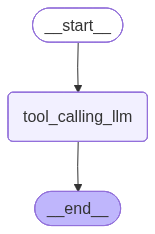

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_lgZo4g6aAWnvRyilgzJs8Ubc)
 Call ID: call_lgZo4g6aAWnvRyilgzJs8Ubc
  Args:
    a: 2
    b: 3


In [15]:
messages = graph.invoke({"messages": HumanMessage(content="Subtract 5 and 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Subtract 5 and 10
================================== Ai Message ==================================
Tool Calls:
  subtract (call_vNxLQjSUkEGPAC8OOZz5cUJi)
 Call ID: call_vNxLQjSUkEGPAC8OOZz5cUJi
  Args:
    a: 5
    b: 10
